In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset
import pickle

import pickle
import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../qnetsur')
import qnetsur
import utils 

plt.style.use("seaborn-v0_8-paper")

font = 16
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate 
* our smallest network topology, the **(2,1)-tree**, and two random tree networks
* a random **20-node tree network**
* a random **100-node tree network**


### 1. Pareto front of a random 2D sample set 

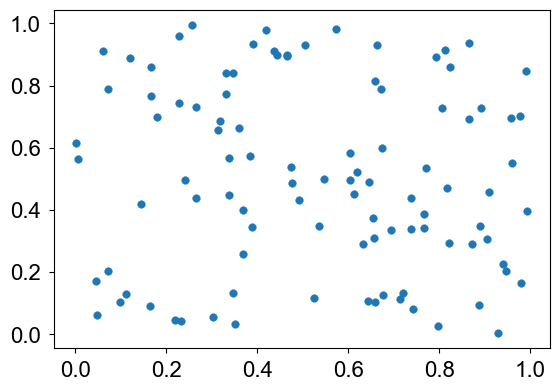

In [26]:
a = 0
b = 1
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` an algorithm implemented by [Tommy Otland, 2021](https://tommyodland.com/articles/2020/pareto-non-dominated-front-as-a-consumer-strategy/#notes-and-references) and is marked in orange below.

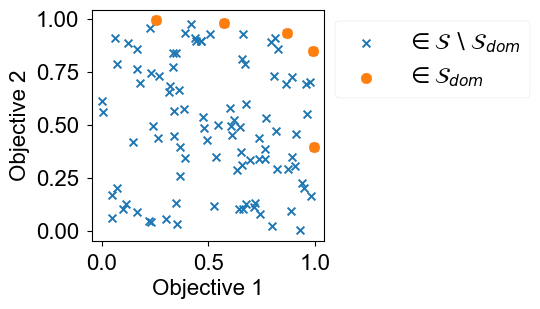

In [27]:
filter = paretoset(sample.T, sense=["max", "max"])
fig, ax = plt.subplots(figsize=[3,3])
plt.ylabel('Objective 2')
plt.xlabel('Objective 1')
plt.scatter(x=sample[0], y=sample[1], label=r'$\in \mathcal{S}\setminus \mathcal{S}_{dom}$', marker='x')
plt.scatter(x=sample[0][filter], y=sample[1][filter], label=r'$\in \mathcal{S}_{dom}$', s=60)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig('simple-pareto.pdf', bbox_inches="tight")

### 2. Pareto analysis of (2,1)-tree of collected solution set

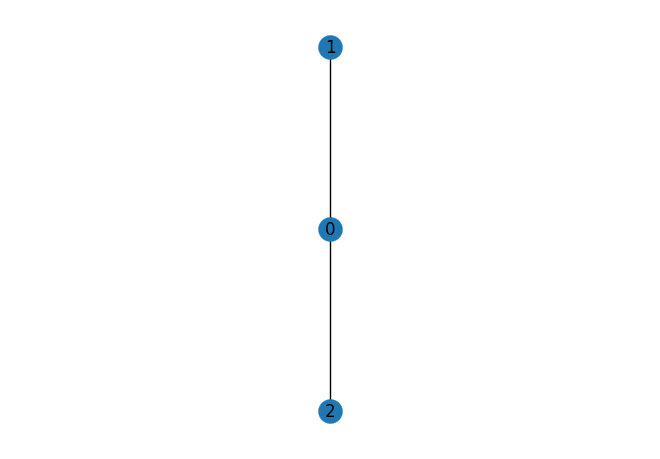

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load result data from `surdata` or run `python surrogate.py --topo tree-2-1 --iterator 30 ` (45 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [7]:
df = pd.read_pickle('../../surdata/cd_simple_20/SU_tree-2-1_100cycles_SEED42_06-02-2024_10:46:06.pkl')
df.columns = df.columns.astype('str')
df.columns

Index(['q_swap0', 'q_swap1', 'Iteration', 'objective', '0', '1', '2', '0_std',
       '1_std', '2_std', '0_raw', '1_raw', '2_raw', 'Simulation [s]',
       'Build [s]', 'Acquisition [s]', 'Total [s]', 'SVR', 'DecisionTree'],
      dtype='object')

<Figure size 640x440 with 0 Axes>

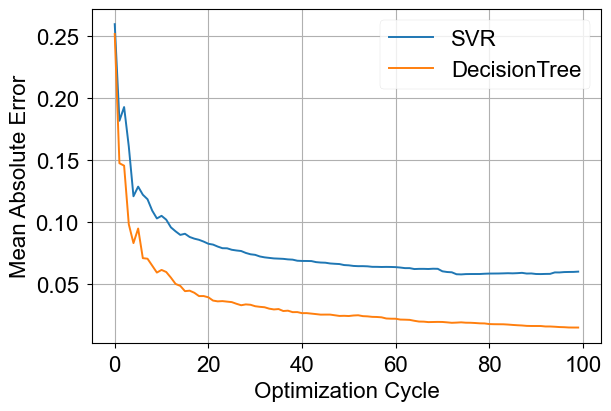

In [8]:
plt.figure()
df[['SVR', 'DecisionTree']].apply(pd.unique).plot()
plt.xlabel('Optimization Cycle')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.tight_layout()
plt.savefig('cd_tree-2-1_mlbenchmarks.pdf')
plt.show()

Excursion: How to calculate which cutoff time to set (given total runtime $T$, $M$, $F_\mathrm{new}$ and $F_\mathrm{app}$ according to [Inesta et al.,2023](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.052615))

In [9]:
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

28.800089826157972

In [10]:
virtual_neighbors = df[df.columns[df.columns.str.fullmatch('\d+')]]

Again calculate the Pareto frontier of the collected set $S_\mathrm{Parto}$

In [11]:
vn = virtual_neighbors.to_numpy()
filter = paretoset(vn, sense=["max"]*3)
print(len(filter))

990


In [12]:
sum(filter)

21

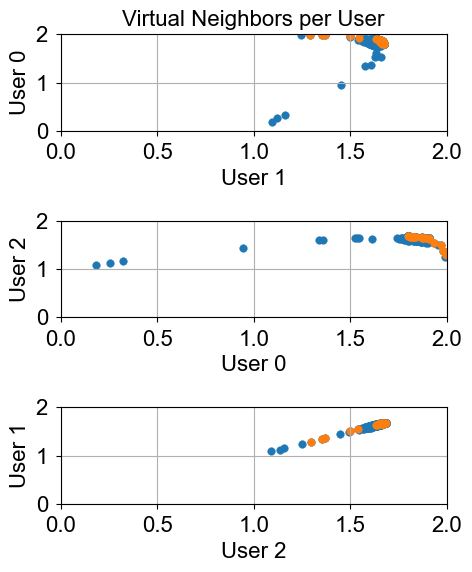

In [13]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,6])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'User {labels[i]}')
    ax.set_ylabel(f'User {labels[i+1]}')
    ax.set_ylim([0,2])
    ax.set_xlim([0,2])
    ax.grid()
axs[0].set_title('Virtual Neighbors per User')
plt.tight_layout()
plt.show()

And as 3D version

In [14]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbors['filter'] = filter
fig = px.scatter_3d(virtual_neighbors, x=virtual_neighbors.columns[0], y=virtual_neighbors.columns[1], z=virtual_neighbors.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

Now, we will plot the distribution of the probability values in $S_\mathrm{Parto}$

In [15]:
X_df = df[df.columns[df.columns.str.contains('q_swap')]]
X_df

,q_swap0,q_swap1
0,0.773956,0.975622
1,0.438878,0.76114
2,0.858598,0.786064
3,0.697368,0.128114
4,0.094177,0.450386
...,...,...
985,0.213601,0.031362
986,0.213601,0.647336
987,0.205564,0.053152
988,0.213606,0.007207


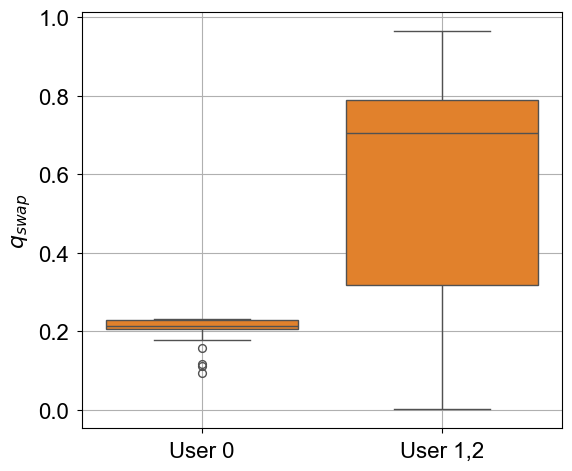

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
g = sns.boxplot(X_df[filter], palette=['tab:orange'])
g.set_xticklabels(['User 0', 'User 1,2'])
plt.ylabel(r'$q_{swap}$')
#plt.title('Pareto Solutions of Collected Frontier')
plt.grid()
plt.tight_layout()
plt.savefig('cd-21tree-pareto.pdf')
plt.show()

We can see that the parameter distribution in the dominating set pretty much coveres the optimal aggregated behaviour of the simulation (in terms of achieved virtual neighbors for each user):

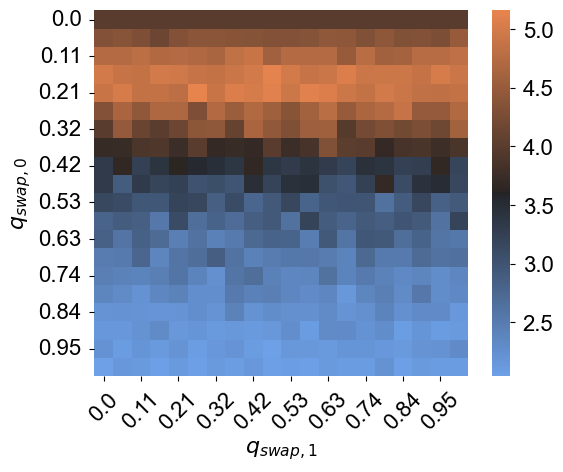

In [19]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
df_plot = pd.read_pickle('../../surdata/cd_simple_20/tree-2-1-heatmap.pkl')
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_plot, cmap=cmap) #cbar_kws={'label': 'Aggregated Virtual Neighbors'}
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
#plt.title('Aggregated Number of Virtual Neighbors')
plt.tight_layout()
plt.savefig('cd-21tree-heatmap.pdf')

Now, we will go to a larger layout, a random **20-node tree network** involving 7 users:

In [ ]:
n=20
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph-plain.pdf')

Load the result data of the surrogate optimization (or execute it with according parameters) and again retrieve the dominating set from the collected training data:

In [ ]:
df = pd.read_pickle('../../surdata/cd_simple_20/SU_randtree-20_100cycles_SEED42_06-02-2024_16:47:15.pkl')

In [ ]:
df.columns = df.columns.astype('str')
vn = df[df.columns[df.columns.str.fullmatch('\d+')]]
df_q = df[df.columns[df.columns.str.contains('q_swap')]]

We get the following values for the overall virtual neighbors

In [ ]:
vn

... from which we retrieve the dominating set

In [ ]:
def get_pareto_frontier(vn, q_set):
    vn_to_analyse = vn
    filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
    return q_set[filter], sum(filter)

(this can take a few seconds)

In [ ]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)
size

Let's look at the overall distribution of swap probability values in the dominating set

In [ ]:
graph.degree

In [ ]:
import re 
df_melted = df_q_filtered.melt(var_name='Node', value_name='Probability')
df_melted['Node Degree'] = df_melted['Node'].apply(lambda x: graph.degree[int(re.sub(r"\D", "", x))])
df_melted_sorted = df_melted.sort_values('Node Degree')
df_melted_sorted[['Node Degree', 'Probability']].corr()

In [ ]:
import re
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_melted_sorted, x='Node', y='Probability', errorbar='pi', ax=ax, linestyles='', color='tab:orange')#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
for idx in labels:
    colors[int(idx)] = cmap(df_q_filtered['q_swap'+idx].mean()) if df_q_filtered['q_swap'+idx].std() <= 0.1 else 'lightblue'
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph.pdf')

The last layout we will investigate is a **100-node network** involing 39 users

In [ ]:
import glob
files = glob.glob('../../surdata/cd_10h/SU*.pkl')
dfs = []
for file in files:
    df = pd.read_pickle(file)
    dfs.append(df)

df = pd.concat(dfs, axis=0)

# df = pd.read_csv('../../surdata/cd-10h/SU_randtree-100_10h.csv')
vn = df[df.columns[df.columns.astype('str').str.fullmatch('\d+')]]
df_q = df[df.columns[df.columns.astype('str').str.contains('q_swap')]]
print(df)

In [ ]:
vn

Let's again retrieve the dominating set (can take a few seconds)

In [ ]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)

Most distributions are widely spread with a sd above 0.2.

In [ ]:
df_q_filtered.std(axis=0)[df_q_filtered.std(axis=0) < 0.2]

In [ ]:
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered[df_q_filtered.columns[df_q_filtered.std(axis=0) < 0.2]], palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree100-pareto.pdf')

At last, let's look at the best found solution of the largest dataset (since we cannot gain too much insight from the Pareto set anymore)

In [ ]:
qvals = df_q.iloc[vn.sum(axis=1).argmax()]
print(qvals)

In [ ]:
n=100
graph = nx.random_tree(n, seed=7)

In [ ]:

cmap =  sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in qvals]
labels = {node: round(val,1) for node, val in enumerate(qvals)}
nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=300)
nx.draw_networkx_labels(graph, pos, labels=labels)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.title(r'Best Found Solution with Time Limit $T = 10$ h')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree-best.pdf')

In [3]:
import pickle
path = '../../surdata/rb_budget_25h/AX_starlight_25.0h_objective-budget_SEED3_05-11-2024_20:35:17.pkl'
with open(path, 'rb') as f:
    x = pickle.load(f)

In [4]:
x

[    trial_index arm_name trial_status generation_method  Utility  \
 0             0      0_0    COMPLETED             Sobol      0.0   
 1             1      1_0    COMPLETED             Sobol  -2152.6   
 2             2      2_0    COMPLETED             Sobol  -1343.6   
 3             3      3_0    COMPLETED             Sobol      0.0   
 4             4      4_0    COMPLETED             Sobol   -517.2   
 ..          ...      ...          ...               ...      ...   
 86           86     86_0    COMPLETED              GPEI     32.0   
 87           87     87_0    COMPLETED              GPEI      0.0   
 88           88     88_0    COMPLETED              GPEI     29.8   
 89           89     89_0    COMPLETED              GPEI     34.6   
 90           90     90_0    COMPLETED              GPEI     32.8   
 
     mem_size_node_0  mem_size_node_1  mem_size_node_2  mem_size_node_3  \
 0                16               31               77               16   
 1                93